In [1]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot

# Custom modules (if needed)
# module_path = os.path.join(os.path.expanduser('~'), 'CustomModules')
# sys.path.append(module_path)
# from telegram_notify import notify
# from plotting_tools import error_band_plot, get_ax_data_range

# Add the parent directory to sys.path (if needed)
from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent.parent))

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

jtplot.style(context='paper', theme='grade3', grid=False, ticks=True)
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [ ]:
path = "../data/bb_circuit_iter30_minsum_lsd0/n144_T12_p0.001/data_1.feather"

In [4]:
from simulations.analysis.collect_bb_simulation_data import aggregate_data

ascending_confidence = False
by = "cluster_frac"

df_agg = aggregate_data(
    by=by,
    n=144,
    p=0.001,
    num_hist_bins=10000,
    ascending_confidence=ascending_confidence,
    value_range=(0, 1),
)

100%|██████████| 500/500 [01:21<00:00,  6.11it/s]


In [12]:
# How many samples are converged & failed?
print(df_agg["num_converged"].sum())
print(df_agg["num_converged_fails"].sum())

423590997
0


In [5]:
from statsmodels.stats.proportion import proportion_confint


def calculate_confidence_interval(n, k, alpha=0.05, method="wilson"):
    p_low, p_upp = proportion_confint(k, n, alpha=alpha, method=method)
    p = (p_low + p_upp) / 2
    delta_p = p_upp - p
    return p, delta_p


if ascending_confidence:
    df_agg = df_agg.iloc[::-1]

shots = df_agg["count"].sum()

# Ignoring convergence

counts, num_fails = (
    df_agg["count"].cumsum(),
    df_agg["num_fails"].cumsum(),
)

pfail, delta_pfail = calculate_confidence_interval(counts, num_fails)
pacc, delta_pacc = calculate_confidence_interval(shots, counts)

# Treating convergence = confident

counts_conv = df_agg["count"] - df_agg["num_converged"]
counts_conv.iloc[0] += df_agg["num_converged"].sum()
counts_conv = counts_conv.cumsum()

assert counts_conv.iloc[-1] == shots

num_fails_conv = df_agg["num_fails"] - df_agg["num_converged_fails"]
num_fails_conv.iloc[0] += df_agg["num_converged_fails"].sum()
num_fails_conv = num_fails_conv.cumsum()

pfail_conv, delta_pfail_conv = calculate_confidence_interval(
    counts_conv, num_fails_conv
)
pacc_conv, delta_pacc_conv = calculate_confidence_interval(shots, counts_conv)

df_ps = pd.DataFrame(index=df_agg.index)

df_ps["p_fail"] = pfail
df_ps["delta_p_fail"] = delta_pfail
df_ps["p_abort"] = 1 - pacc
df_ps["delta_p_abort"] = delta_pacc

df_ps["p_fail_conv"] = pfail_conv
df_ps["delta_p_fail_conv"] = delta_pfail_conv
df_ps["p_abort_conv"] = 1 - pacc_conv
df_ps["delta_p_abort_conv"] = delta_pacc_conv

df_ps["count"] = counts
df_ps["num_fails"] = num_fails
df_ps["count_conv"] = counts_conv
df_ps["num_fails_conv"] = num_fails_conv

df_ps = df_ps.reset_index()

df_ps.head(10)

,n,T,p,cluster_frac,p_fail,delta_p_fail,p_abort,delta_p_abort,p_fail_conv,delta_p_fail_conv,p_abort_conv,delta_p_abort_conv,count,num_fails,count_conv,num_fails_conv
0,144,12,0.001,0.0001,7.961875e-06,7.961875e-06,0.999759,9.625394e-07,4.534396e-09,4.534396e-09,0.576409,0.000031,241237,0,423590997,0
1,144,12,0.001,0.0002,1.350608e-06,1.350608e-06,0.998578,2.335646e-06,4.534214e-09,4.534214e-09,0.576392,0.000031,1422118,0,423608021,0
2,144,12,0.001,0.0003,3.422847e-07,3.422847e-07,0.994389,4.629833e-06,4.532302e-09,4.532302e-09,0.576213,0.000031,5611492,0,423786765,0
3,144,12,0.001,0.0004,1.150048e-07,1.150048e-07,0.983299,7.942660e-06,4.522431e-09,4.522431e-09,0.575288,0.000031,16701301,0,424711677,0
4,144,12,0.001,0.0005,4.791054e-08,4.791054e-08,0.959910,1.215853e-05,4.488984e-09,4.488984e-09,0.572124,0.000031,40089911,0,427876223,0
5,144,12,0.001,0.0006,2.365919e-08,2.365919e-08,0.918817,1.692761e-05,4.405822e-09,4.405822e-09,0.564047,0.000031,81183231,0,435952559,0
6,144,12,0.001,0.0007,1.341072e-08,1.341072e-08,0.856777,2.171145e-05,4.245659e-09,4.245659e-09,0.547602,0.000031,143223392,0,452398369,0
7,144,12,0.001,0.0008,8.516220e-09,8.516220e-09,0.774462,2.590346e-05,3.998979e-09,3.998979e-09,0.519695,0.000031,225537771,0,480304913,0
8,144,12,0.001,0.0009,5.939737e-09,5.939737e-09,0.676631,2.899168e-05,3.687045e-09,3.687045e-09,0.479060,0.000031,323369426,0,520940051,0
9,144,12,0.001,0.0010,4.477275e-09,4.477275e-09,0.571005,3.067568e-05,3.352632e-09,3.352632e-09,0.427098,0.000031,428995210,0,572901972,0


In [6]:
def error_band_plot(data, x, y, delta_y, ax, color=None, alpha=0.3, **kwargs):
    """
    Plot a line with confidence interval.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame containing the data to plot
    x : str
        Column name for x-axis
    y : str
        Column name for y-axis
    delta_y : str
        Column name for confidence interval
    ax : matplotlib.axes.Axes
        Axes to plot on
    color : str or tuple
        Color for the line and confidence interval
    alpha : float, optional
        Alpha value for confidence interval, defaults to 0.3
    """
    sns.lineplot(data=data, x=x, y=y, ax=ax, color=color, **kwargs)
    ax.fill_between(
        data[x],
        data[y] - data[delta_y],
        data[y] + data[delta_y],
        alpha=alpha,
        color=color,
    )

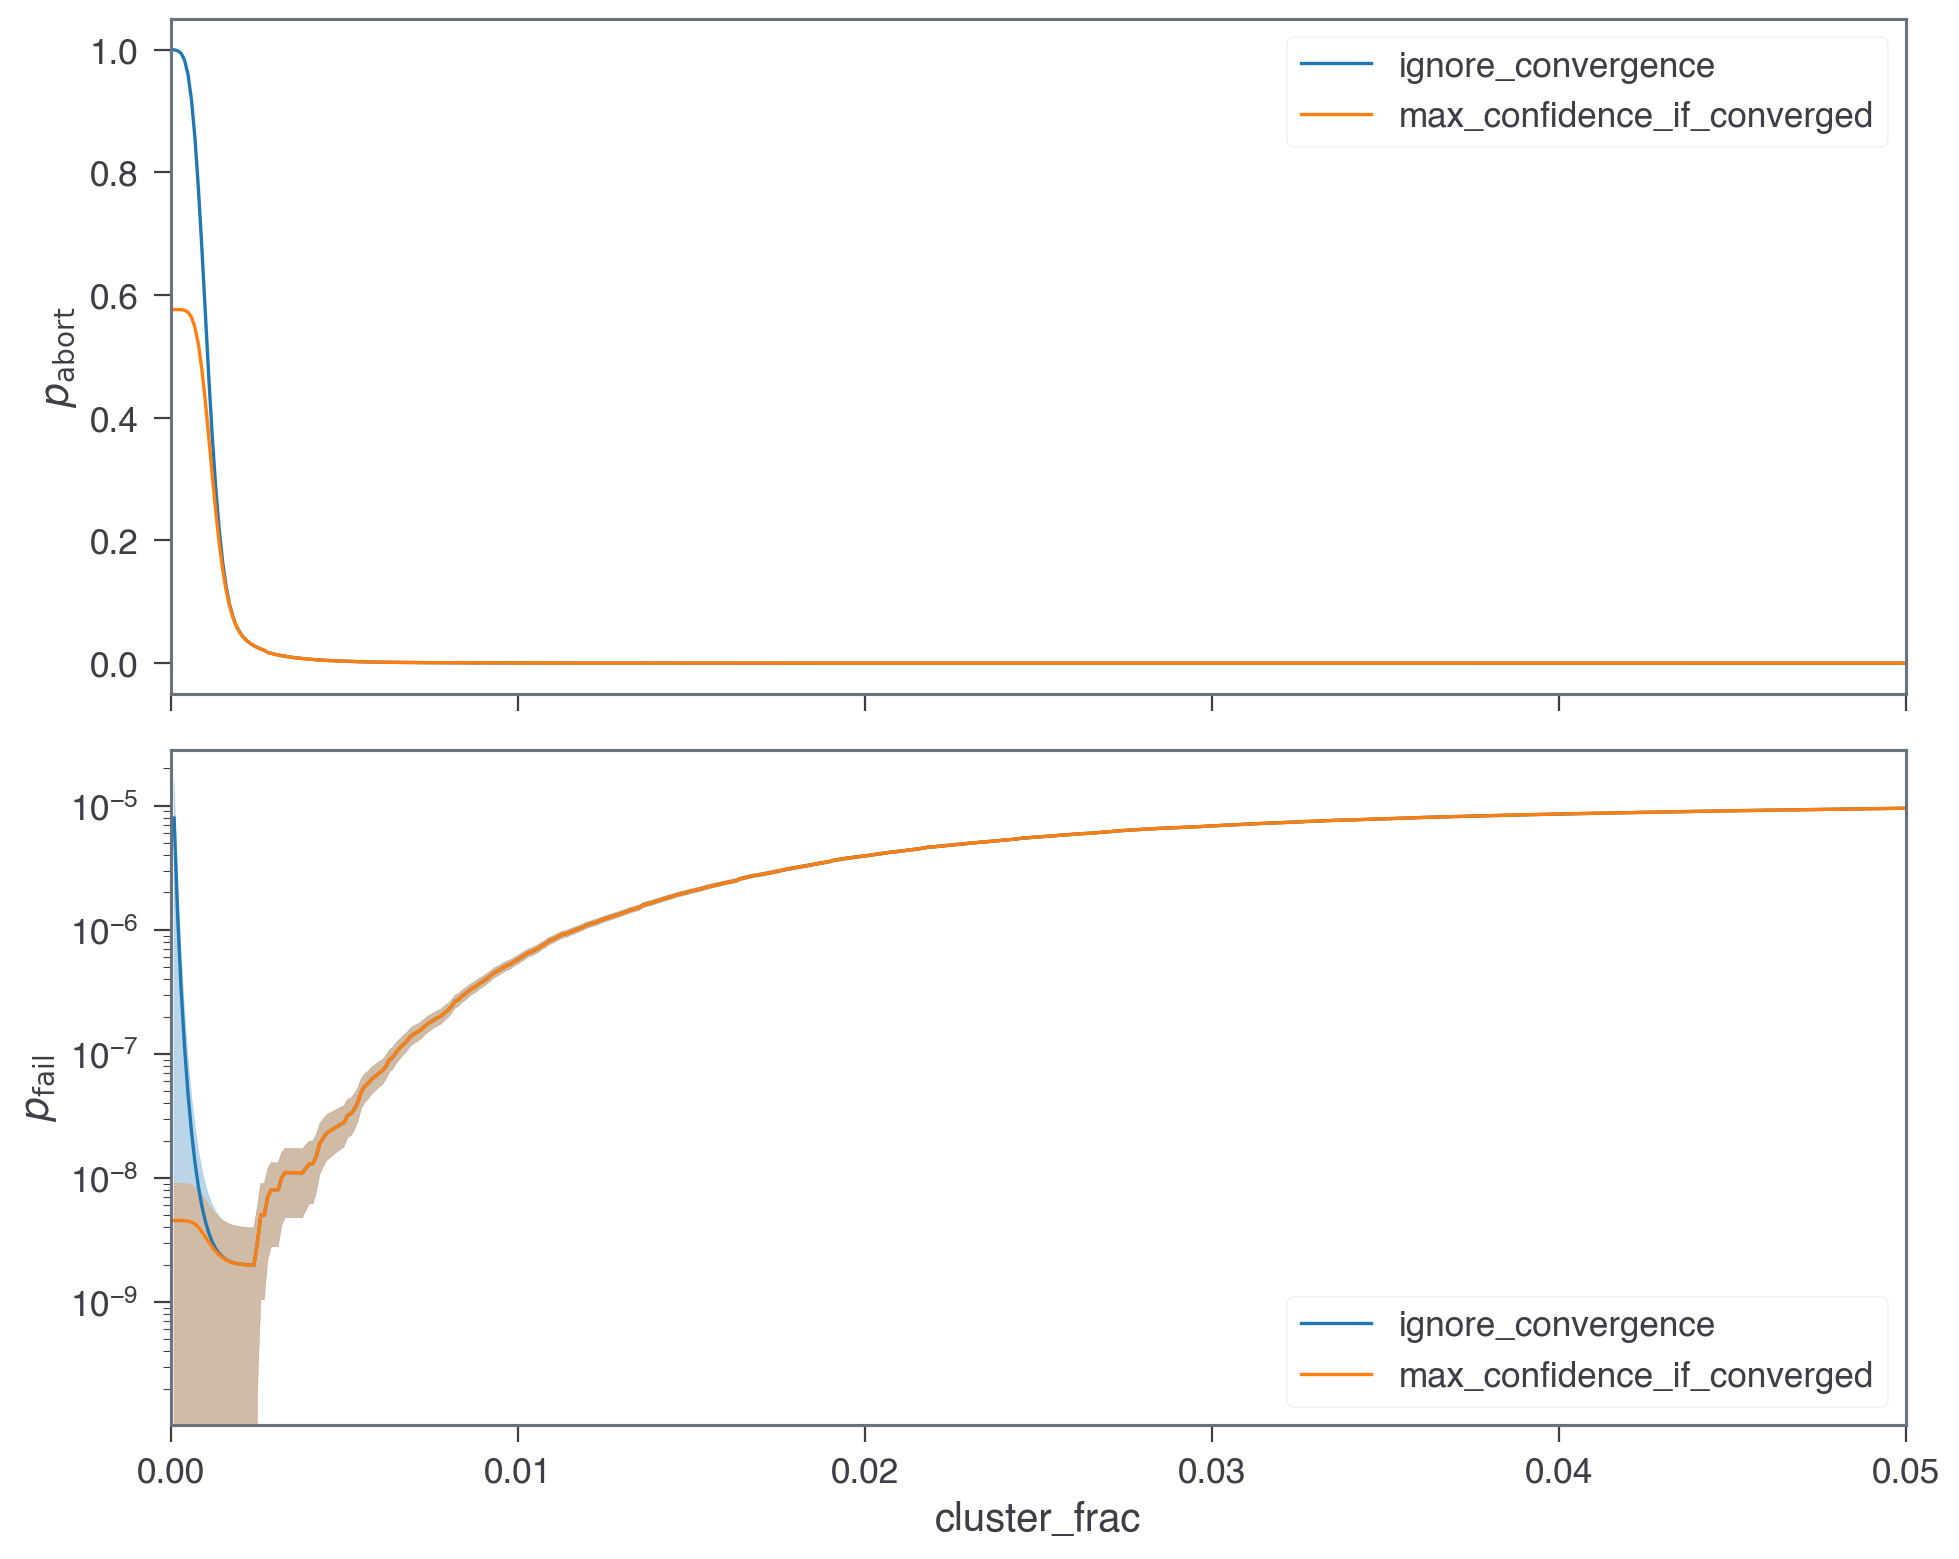

In [8]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

error_band_plot(
    data=df_ps,
    x=by,
    y="p_abort",
    delta_y="delta_p_abort",
    ax=axes[0],
    color=COLORS(0),
    label="ignore_convergence",
)

error_band_plot(
    data=df_ps,
    x=by,
    y="p_abort_conv",
    delta_y="delta_p_abort_conv",
    ax=axes[0],
    color=COLORS(1),
    label="max_confidence_if_converged",
)

error_band_plot(
    data=df_ps,
    x=by,
    y="p_fail",
    delta_y="delta_p_fail",
    ax=axes[1],
    color=COLORS(0),
    label="ignore_convergence",
)
error_band_plot(
    data=df_ps,
    x=by,
    y="p_fail_conv",
    delta_y="delta_p_fail_conv",
    ax=axes[1],
    color=COLORS(1),
    label="max_confidence_if_converged",
)

# Set titles and labels
axes[0].set_ylabel(r"$p_\mathrm{abort}$")
axes[1].set_xlabel(by)
axes[1].set_ylabel(r"$p_\mathrm{fail}$")
axes[1].set_yscale("log")

for ax in axes:
    ax.set_xlim(0, 0.05)

for ax in axes:
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

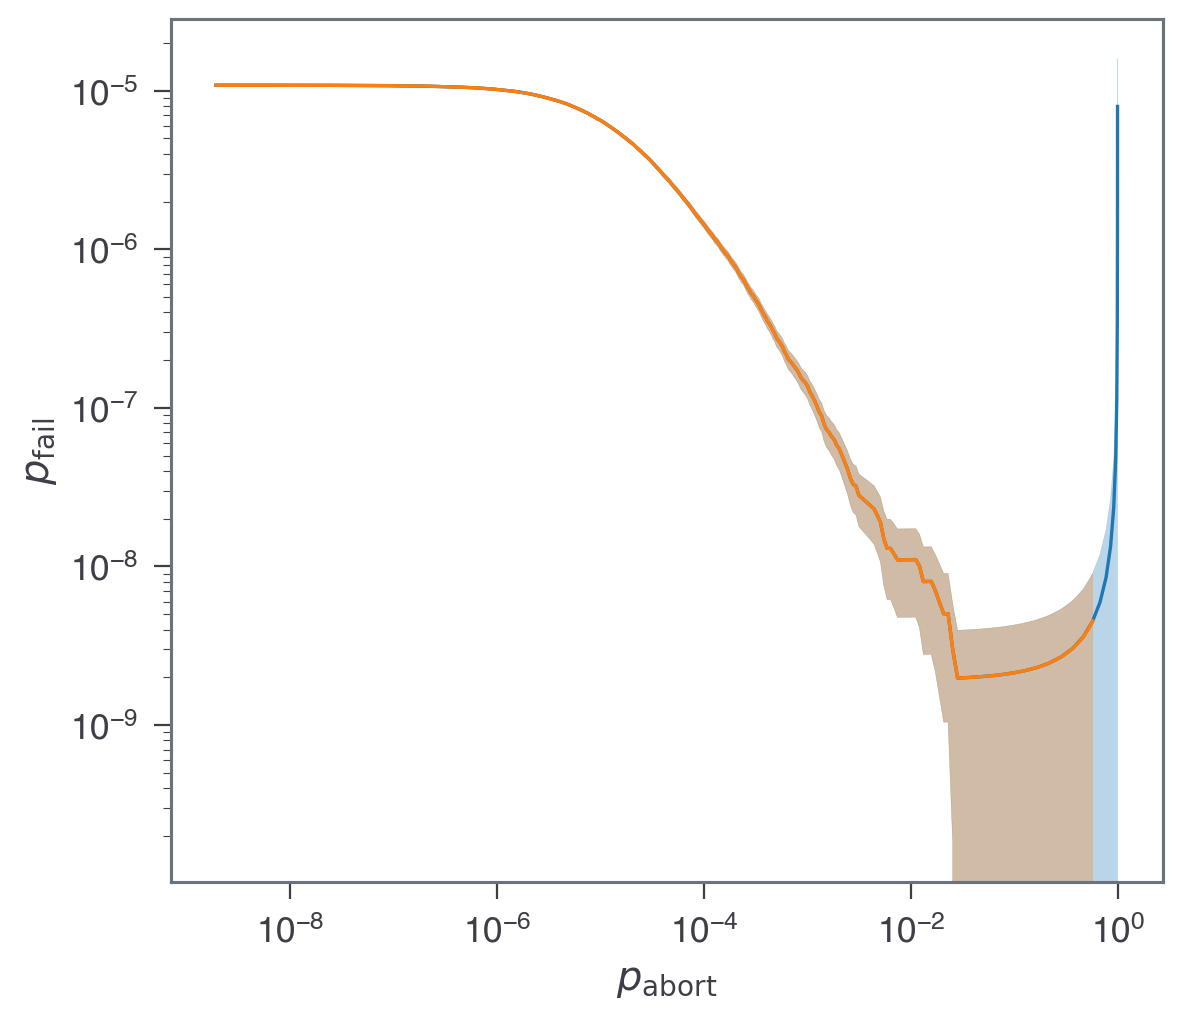

In [11]:
plt.plot(df_ps["p_abort"], df_ps["p_fail"], color=COLORS(0))
plt.fill_between(
    df_ps["p_abort"],
    df_ps["p_fail"] - df_ps["delta_p_fail"],
    df_ps["p_fail"] + df_ps["delta_p_fail"],
    alpha=0.3,
    color=COLORS(0),
)

plt.plot(df_ps["p_abort_conv"], df_ps["p_fail_conv"], color=COLORS(1))
plt.fill_between(
    df_ps["p_abort_conv"],
    df_ps["p_fail_conv"] - df_ps["delta_p_fail_conv"],
    df_ps["p_fail_conv"] + df_ps["delta_p_fail_conv"],
    alpha=0.3,
    color=COLORS(1),
)

plt.xscale("log")
# plt.xlim(0, 1)
plt.yscale("log")

plt.xlabel(r"$p_\mathrm{abort}$")
plt.ylabel(r"$p_\mathrm{fail}$")
plt.show()